In [59]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [60]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

In [61]:
tf.__version__

'2.8.0'

In [62]:
# TensorFlow data generator
train_dataset = h5py.File('datasets/train_signs.h5')
test_dataset = h5py.File('datasets/test_signs.h5')

x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [63]:
# Since TensorFlow Datasets are generators, 
# you can't access directly the contents unless you iterate over them in a for loop, or by explicitly creating a Python iterator using iter and consuming its elements using next. 
# Also, you can inspect the shape and dtype of each element using the element_spec attribute.
print(x_train.element_spec)


TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [64]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


2022-04-01 22:06:20.769548: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


In [65]:
# The dataset that you'll be using during this assignment is a subset of the sign language digits. 
# It contains six different classes representing the digits from 0 to 5
unique_labels = set()
for element in y_train:
    unique_labels.add(element.numpy())
print(unique_labels)

{0, 1, 2, 3, 4, 5}


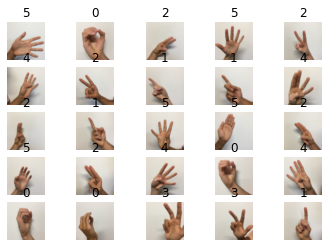

In [66]:
# Check some images in the dataset
images_iter = iter(x_train)
labels_iter = iter(y_train)
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")   

In [67]:
# There's one more additional difference between TensorFlow datasets and Numpy arrays: 
# If you need to transform one, you would invoke the map method to apply the function passed as an argument to each of the elements.
def normalize(image):
    image = tf.cast(image,tf.float32)/255.0
    image = tf.reshape(image,[-1,])
    return image

new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

new_train.element_spec

TensorSpec(shape=(12288,), dtype=tf.float32, name=None)

In [68]:
# Linear function
# Linear function
def linear_function():
    np.random.seed(1)

    X = tf.constant(np.random.randn(3,1),name = 'X')
    W = tf.Variable(np.random.randn(4,3),name = 'W')
    b = tf.Variable(np.random.randn(4,1),name = 'b')
    Y = tf.add(tf.matmul(W,X),b)

    return Y


In [69]:
# Computing the sigmoid
def sigmoid(z):
    z = tf.cast(z,tf.float32)
    a = tf.keras.activations.sigmoid(z)
    return a

In [70]:
# One hot encodings
def one_hot_matrix(label,depth=6):
    one_hot = tf.reshape(tf.one_hot(label,depth,axis=0),(depth,))
    return one_hot
    

In [71]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print("Test 1:",result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 1. ,0., 0.] ), "Wrong output. Use tf.one_hot"
    label_2 = [2]
    result = target(label_2, depth)
    print("Test 2:", result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 0. ,1., 0.] ), "Wrong output. Use tf.reshape as instructed"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
All test passed


In [72]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)
print(next(iter(new_y_test)))

tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


In [73]:
# Initialize the parameters
def initialize_parameters():
    initializer = tf.keras.initializers.glorot_normal(seed=1)

    W1 = tf.Variable(tf.keras.initializers.glorot_normal(seed=1)(shape=(25,12288)))
    b1 = tf.Variable(tf.keras.initializers.glorot_normal(seed=1)(shape=(25, 1)))
    W2 = tf.Variable(tf.keras.initializers.glorot_normal(seed=1)(shape=(12, 25)))
    b2 = tf.Variable(tf.keras.initializers.glorot_normal(seed=1)(shape=(12,1)))
    W3 = tf.Variable(tf.keras.initializers.glorot_normal(seed=1)(shape=(6, 12)))
    b3 = tf.Variable(tf.keras.initializers.glorot_normal(seed=1)(shape=(6,1)))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    return parameters

In [74]:
parameters = initialize_parameters()

In [75]:
# Building your first neural network in TensorFlow
# Implement forward propagation
# Forward propagation
def forward_propagation(X,parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.math.add(tf.linalg.matmul(W1,X),b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2,A1),b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3,A2),b3)

    return Z3

In [82]:
# Compute the cost
def compute_cost(logits,labels):
    loss = tf.keras.losses.categorical_crossentropy(tf.transpose(labels),tf.transpose(logits),from_logits=True)
    cost = tf.reduce_mean(loss)

    return cost

In [86]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    #(1 line)
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # We can get the number of elements of a dataset using the cardinality method
    m = dataset.cardinality().numpy()
    
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    #X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    #Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_states()
        
        for (minibatch_X, minibatch_Y) in minibatches:
            
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)

                # 2. loss
                minibatch_cost = compute_cost(Z3, tf.transpose(minibatch_Y))

            # We accumulate the accuracy of all the batches
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost
        
        # We divide the epoch cost over the number of samples
        epoch_cost /= m

        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print("Train accuracy:", train_accuracy.result())
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_cost)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()


    return parameters, costs, train_acc, test_acc

In [87]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

Cost after epoch 0: 0.056918
Train accuracy: tf.Tensor(0.16666667, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.20833333, shape=(), dtype=float32)
Cost after epoch 10: 0.049478
Train accuracy: tf.Tensor(0.41296297, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.375, shape=(), dtype=float32)
Cost after epoch 20: 0.044167
Train accuracy: tf.Tensor(0.4888889, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.46666667, shape=(), dtype=float32)
Cost after epoch 30: 0.039030
Train accuracy: tf.Tensor(0.5675926, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.49166667, shape=(), dtype=float32)
Cost after epoch 40: 0.034898
Train accuracy: tf.Tensor(0.6388889, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.55833334, shape=(), dtype=float32)
Cost after epoch 50: 0.031478
Train accuracy: tf.Tensor(0.6787037, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.65, shape=(), dtype=float32)
Cost after epoch 60: 0.028648
Train accuracy: tf.Tensor(0.71944445, shape=(), dtype=fl

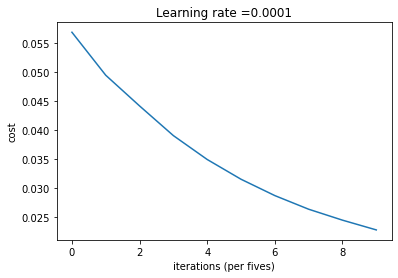

In [88]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

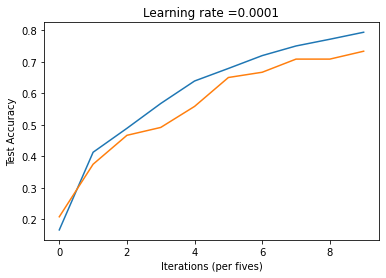

In [90]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('Iterations (per fives)')
plt.title('Learning rate = '+ str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('Iterations (per fives)')
plt.title('Learning rate =' +str(0.0001))
plt.show()